# Urban Networks and Wealth Concentration

To demonstrate that increased inequality (wealth concentration) may occur as a result of network effects in urban centres, we ran a simple Agent Based Model (ABM). The ABM is an extension of the well-known Boltzmann wealth model. According to that model, money is conserved in a closed economic system and agent money comes to be distributed in a way analgous to energy in a closed physical system of gases. In the simplest case, agents begin the simulation with a given amount of 'money'---just a scalar representing available money. Then, each step in the simulation, each agent randomly chooses another agent to give a fixed unit of money to. As the simulation progress the distribution of money among the agents converges to a Boltzmann (exponential) distribution [Dragulescu and Yakovenko](https://link.springer.com/article/10.1007/s100510070114). We extended the model based on code provided in an introductory [tutorial](https://mesa.readthedocs.io/en/latest/tutorials/intro_tutorial.html) for learning [Mesa](https://mesa.readthedocs.io/en/stable/), a popular Python package for agent-based simulations. Our extension accounts for network effects by placing all agents into a network at the start of the simulation and then limiting trades among agents to those agents connected by an edge in the network. To explore networks effects, we included a preferential attachement parameter that altered the probability of connections among agents, with higher levels of the parameter favouring new connections for agents with more existing connections. Thus, better connected agents were more likely to acquire additional connections. Then, we ran simulations where we varied the magnitude of the preferential attachement parameter---thereby verying the strength of the preference for attachments to agents based on their existing number of connections---in order to explore the impact of network strucutre on wealth distribution and Gini coefficient by the end of the simulation. The rest of this notebook walks through building the model and visualizing the results.

## Setting up the model

We used a number of Python packages, in addition to Mesa, for data manipulation and visualization:

In [2]:
# ABM
import mesa

# Data viz
import plotly_express as px
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns

# data analysis
import numpy as np
import pandas as pd
import networkx as nx

Here we edited some global plot styling parameters to create consistent looking plots.

In [3]:
# Plot styling
plt.style.use('ggplot')
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Verdana']
plt.rcParams['font.weight'] = 'light'


### Agents
Mesa uses a object-oriented approach to agent-based modelling. The major components of the model are the agent class and the model class. Each agent in our model needs to keep track of its current wealth, which we set at '1' to begin with. The agents each maintained their own 'step' method, which determines what they do during each iteration (sometimes called a 'step' or a 'tick' in the agent-based modelling literature). In our case, the model is very simple and so is agent behaviour. Each step, the agents searched for a transacation partner. The choice of transaction partner was random in the basic Boltzmann wealth model and it was random in our extension as well. But, to explore network effects we limited potential partners to the agents with whom the acting agent had a connection in the network. In order to detemrine the pool of connected agents, each agent called their 'get_connected_agents' method, which consulted a network adjacency matrix to determine their connections. Once identified, the acting agent then checked to see if they had any 'money' to give the selected other agent. If they did, they then increased the other agent's wealth by 1 unit and subtracted 1 unit from their own wealth.

In [4]:
class MoneyAgent(mesa.Agent):
    """Agent class."""

    def __init__(self, unique_id, model):
        # Pass the parameters to the parent class.
        super().__init__(unique_id, model)

        # Create the agent's variable and set the initial values.
        self.wealth = 1

    def step(self):
        # Verify agent has some wealth
        if self.wealth > 0:
            if self.model.network:
                connected_agents = self.get_connected_agents()
                if connected_agents:
                    recipient_id = self.random.choice(connected_agents)
                    other_agent = self.model.schedule.agents[recipient_id]
                else:
                    other_agent = None
            else:
                other_agent = self.random.choice(self.model.schedule.agents)
            if other_agent is not None:
                other_agent.wealth += 1
                self.wealth -= 1
    
    def get_connected_agents(self):
        # Get indices of connected agents from the adjacency matrix
        connected = np.nonzero(self.model.adjacency_matrix[self.unique_id])[0]
        return list(connected)

### Model
In Mesa ABMs, the model class defines and instaniates the agents and the environment in which they will operate. It also controlls the scheduler, which detemrines the order in which agents are told to call their 'step' method. In our case, the model class needed to maintain some basic variables (like the number of agents and how the scheduler should manage calling agents), but it also needed to set up and maintain the agent network. To represent the network, we used an adjacency matrix. The rows and columns of the matrix refer to agents and the intersection (a cell in the matrix) contains a 1 if the relevant agents are connected in the network and a 0 if they are not. The model class also owned a parameter called 'prefernece_strength', which determined the probability that a 'calling' agent would be linked to a 'target' agent based on the number of links the target agent already possessed. The model class, when instantiated, subsquently instantiates a number, $N$, of agents and then instaniates the network by creating and storing an adjacency matrix.

When the model class called its 'init_network' method, it would perform the following steps to create the network: 

1. instantiate an $N x N$ adjacency matrix filled with zeros,
2. randomly select a 'calling' agent, 
3. detemrine the number of connections for every other agent (the 'degree' of each other agent, which would be 0 to start) by summing the appropriate row or column in the adjacency matrix,
4. calculate the probability weights for the other agents using the function, $w_i = (d_i + 1)^{s}$, where $w_i$ refers to the probability weight for agent $i$, $d_i$ refers to the current degree of agent $i$ in the network, and $s$ refers to 'ps' or 'preference_strength' parameter.
5. set the calling agent's weight to 0 (because self connections were not permitted),
6. normalize the weights to create probabilities, $p_i = \frac{w_i}{\sum{w_i}}$
7. randomly select another agent to connect the calling agent to,
8. repeat $M$ times for each agent where $M$ is a parameter passed to the model class.

It's important to note, that we include a 'network' parameter in the model class definiton. When this parameter was set to 'False', the model did not initialize a network and the agents would trade completely at random, as in the original Boltzmann wealth model.

In [5]:
class MoneyModel(mesa.Model):
    """Model class."""

    def __init__(self, N, M, ps=0.5, network=True):
        super().__init__()
        self.num_agents = N
        self.M = M
        self.network = network
        # Create scheduler and assign it to the model
        self.schedule = mesa.time.RandomActivation(self)
        # adjacency matrix
        self.adjacency_matrix = np.zeros((N, N), dtype=int)
        # preferential attachment strength
        self.preference_strength = ps

        # Create agents
        for i in range(self.num_agents):
            a = MoneyAgent(i, self)
            # Add the agent to the scheduler
            self.schedule.add(a)
        
        # initialize agent network
        if self.network:
            self.init_network()
        
    def init_network(self):
        for i in range(1, self.num_agents):
            degrees = self.adjacency_matrix.sum(axis=0).astype(float)  # Degree of each agent
            # Attraction: higher degree increases the chance of new connections
            probabilities = (degrees + 1) ** self.preference_strength
            # don't choose self, i
            probabilities[i] = 0
            # Normalize to get probabilities
            probabilities /= probabilities.sum()

            for _ in range(self.M):
                # Choose an agent to connect with based on probabilities
                chosen_agent = np.random.choice(self.num_agents, p=probabilities)
                # Create a bi-directional connection
                self.adjacency_matrix[i, chosen_agent] = 1
                self.adjacency_matrix[chosen_agent, i] = 1
                
    def step(self):
        """Advance the model by one step/tick"""

        # call the step method of each agent
        self.schedule.step()

### Preferential Attachment Weights
There are many ways to structure a network and preferential attachment is only one option. It has often been used in network simulations for its simplicity and the fact that it has some real-world likeness to it. People who are well connected at one time seem more likely than others to acquire further connections. And, there are many ways to potentially weight the attachment probabilties. The way we selected is a simple one that takes only two parameters: degree, and an arbitrary scalar representing the strengh of the preference. We visuzalized the impact of the weighting parameter on the attachement weighting function with respect to degree as follows. 

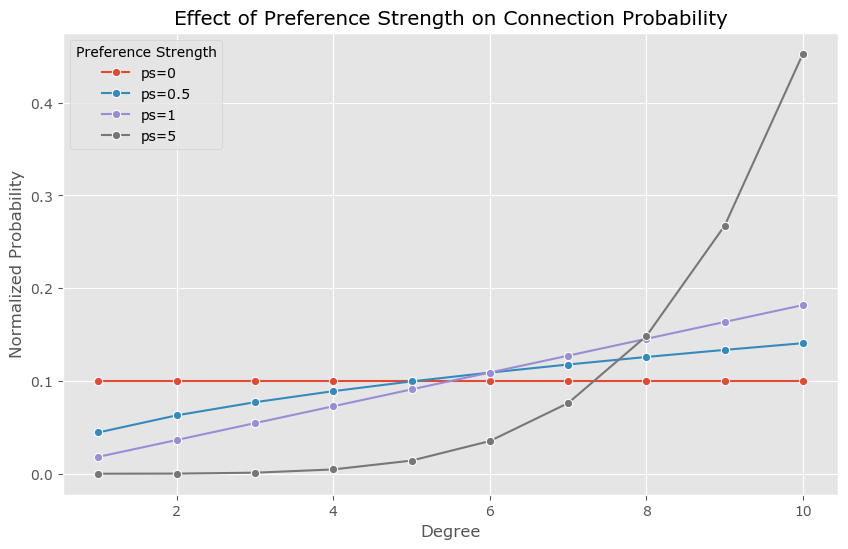

In [6]:
# Define degrees range
degrees = np.arange(1.0, 11.0)  # From 1 to 10
mean_degree = np.mean(degrees)

# Define preference_strength values for examples
preference_strengths = [0, 0.5, 1, 5]

# Prepare data for plotting
data = []
for ps in preference_strengths:
    probabilities = degrees ** ps
    probabilities /= probabilities.sum()  # Normalize
    for degree, probability in zip(degrees, probabilities):
        data.append({'Degree': degree, 'Probability': probability, 'Preference Strength': f'ps={ps}'})

df = pd.DataFrame(data)

# Create the line plot
plt.figure(figsize=(10, 6))
sns.lineplot(data=df, x='Degree', y='Probability', hue='Preference Strength', marker='o')

# Customize plot
plt.title('Effect of Preference Strength on Connection Probability')
plt.xlabel('Degree')
plt.ylabel('Normalized Probability')
plt.legend(title='Preference Strength')

plt.show()

As the plot shows, if preference strength is set to $0$, there is no weighting and, thus, current degree has no effect on the probability of recieving further links (no preferential attachment). When the strength parameter is set to $1$, the relationship is linear so that agents with higher numbers of existing attachments have a linear advantage for recieving further connections. There are, however, nonlinear effects for other strength values, with values $\lt 1$ creating a function of increasing attachment odds for higher degrees but at a declining rate as degree increases. Values $\gt 1$ lead to significant, nonlinear, increases in the odds of further links as degree increases.

### Test Run
To test the model setup, we ran a single instance (which can, of course, be run any number of times with different settings using this notebook) by instantiating the model class with the following parameters:

1. N = 50
2. M = 50
3. ps = None
4. network = False

These settings created a model with 50 agents. Each agent made 50 attempts to connect to other agents during network initialization, with no prefernece strength set (None) and the network parameter set to false. In this case, the model is exactly the same as the Boltzmann wealth model in the Mesa tutorial. Agents randomly selected other agents to give 'money' to and we could extract and assess the results to ensure they looked as expected from the basic model. We could then also compare these to the results when we included network effects. In the simulation that follows, we ran the model for 10 steps by calling the 'model.step()' method 10 times in a loop.

In [7]:
model = MoneyModel(50, 50, None, False)
for i in range(10):
    model.step()

c:\Users\carleton\AppData\Local\miniconda3\envs\abm\Lib\site-packages\mesa\time.py:82: FutureWarning: The AgentSet is experimental. It may be changed or removed in any and all future releases, including patch releases.
We would love to hear what you think about this new feature. If you have any thoughts, share them with us here: https://github.com/projectmesa/mesa/discussions/1919
  self._agents: AgentSet = AgentSet(agents, model)


After running the model, we extracted the wealth of each agent,

In [8]:
agent_wealth = [a.wealth for a in model.schedule.agents]

And plotted the results using a histogram,

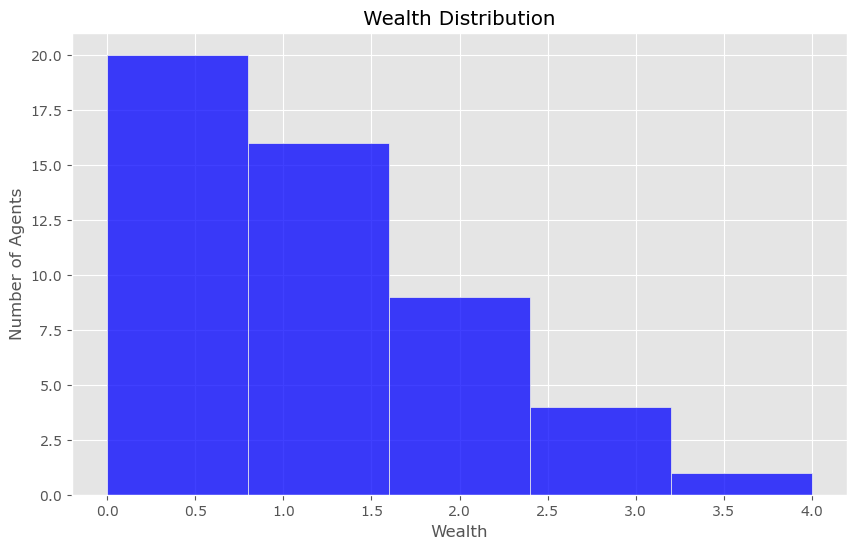

In [9]:
plt.figure(figsize=(10, 6))  # Set the figure size
sns.histplot(agent_wealth, bins=len(set(agent_wealth)), kde=False, color='blue')
plt.title('Wealth Distribution')  # Set the title
plt.xlabel('Wealth')  # Set x-axis label
plt.ylabel('Number of Agents')  # Set y-axis label
plt.show()

As expected, after even only 10 iterations the distribution of wealth in the simulation is highly uneven, approaching a Boltzmann distribution.

### Inequality
We then used a Gini coefficient to measure and compare inquality in the simulation. Our definition for the coefficient comes from a simplified version that appears to have originally been published in [Sen (1973)](https://www.jstor.org/stable/4362925) and then listed along with a large number of alternates in [Muñoz et al. (2023)](https://doi.org/10.1177/00491241231176847).

In [10]:
def gini_coefficient(wealths):
    """
    Calculate the Gini coefficient from a list of agent wealth.
    Used a simpllified, oft repeated, version of the Gini coefficient
    reproduced in https://doi.org/10.1177/00491241231176847 (between eq.5 and eq.6)
    """
    n = len(wealths)
    if n == 0:
        return None  # Avoid division by zero if wealths is empty, which should be impossible by design
    
    # sort wealths
    sorted_wealths = sorted(wealths)
    
    # total wealth
    total_wealth = sum(sorted_wealths)
    
    # Check for total wealth to avoid division by zero in completely equal simulations---though this should be impossible by design
    if total_wealth == 0:
        return 0
    
    weighted_sum = 0
    for i, wealth in enumerate(sorted_wealths, 1):
        weighted_sum += i * wealth
    
    # The Gini coefficient
    gini = ( (2 * weighted_sum) / (n * total_wealth) ) - ( (n + 1) / n )
    return gini

### Multiple runs
We tested the simulation again, this time including network effects and calculating a Gini coefficient for each run. The model was run 100 times with the following parameter settings:

1. N = 50
2. M = 50
3. ps = 1
4. network = True

Again, each run of the model included 10 steps, after which we extracted the agent wealth list and used it to calculate a Gini cofficient. This resulted in 100 Gini coefficients.

In [11]:
all_wealth = []
gini = []
# This runs the model 100 times, each model executing 10 steps.
for j in range(100):
    run_wealth = []
    # Run the model
    model = MoneyModel(50, 50, 1, True)
    for i in range(10):
        model.step()

    # Store the results
    for agent in model.schedule.agents:
        all_wealth.append(agent.wealth)
        run_wealth.append(agent.wealth)
    
    # run wealth
    gini.append(gini_coefficient(run_wealth))
mean_gini = np.mean(gini)
mean_gini

0.613376

The mean Gini coefficient from this simulation was $G \approx 0.61$. As one might expext, then, when we plotted the histogram of agent wealth from this simulation (see below), the inequality was markedly more extreme than we saw previously in simulations with no network effects.

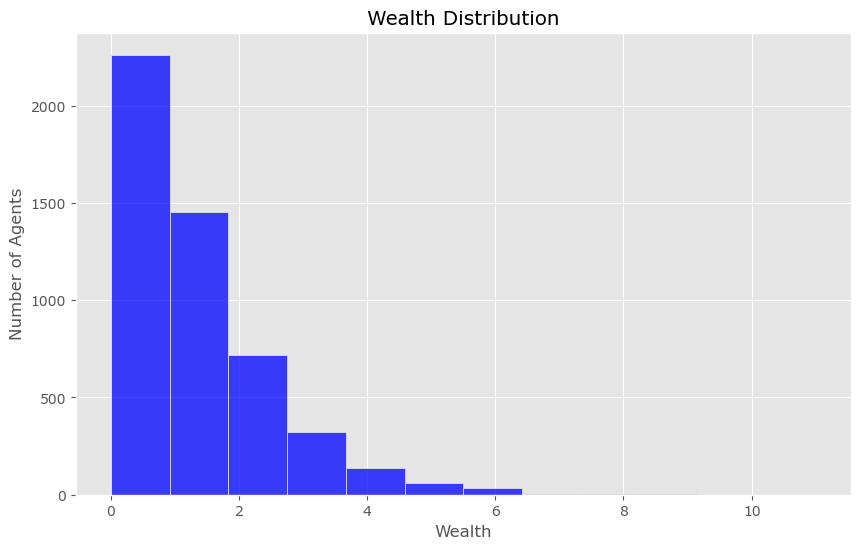

In [12]:
plt.figure(figsize=(10, 6))  # Set the figure size
sns.histplot(all_wealth, bins=len(set(all_wealth)), kde=False, color='blue')
plt.title('Wealth Distribution')  # Set the title
plt.xlabel('Wealth')  # Set x-axis label
plt.ylabel('Number of Agents')  # Set y-axis label
plt.show()

### Exploring Network Effect Paramater Space
To see how important network effects can be, we ran a final simulation in which we varied the magnitude of the 'preferential_strength' parameter. We opted for exploring 8 levels of the paramater: [0, 0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5]. The model was run 100 times at each level of 'preferential_strength' and the results aggregated by parameter level. Of course, any values could be chosen, but we selected these after some initial ad hoc testing to simply illustrate the overall pattern. We also reduced the number of agents in the model to 20 (down from 50 used previously) in order to create more visually impactful representations of the network---too many nodes and edges in the networks made them hard to vizualize. But, as you could see by changing the settings below and rerunning the simulation, increasing the nummber of agents just makes the pattern all the clearer.

In [13]:
preferential_strength = np.arange(0, 4, 0.5)
niter = 100
gini_results = np.zeros((niter, len(preferential_strength)))
adjacency_matrices = []

for index, level in enumerate(preferential_strength):
    get_adj_mat = True
    for iteration in range(niter):
        model = MoneyModel(20, 20, level, True)
        if get_adj_mat:
            adjacency_matrices.append(model.adjacency_matrix)
            get_adj_mat = False
        run_wealth = []
        for _ in range(10):
            model.step()
        for agent in model.schedule.agents:
            run_wealth.append(agent.wealth)
        
        # Calculate the Gini coefficient and store it
        gini_results[iteration, index] = gini_coefficient(run_wealth)

To vizualize the results, we built a custom plot with two main panels. In the top panel, we inlcuded one (the first) network created during the model class initialization for each level of 'prefential_strength'. In the bottom panel, we plotted a series of box plots representing Gini coefficient sample distributions corresponding to each level of 'preferential_strength'.

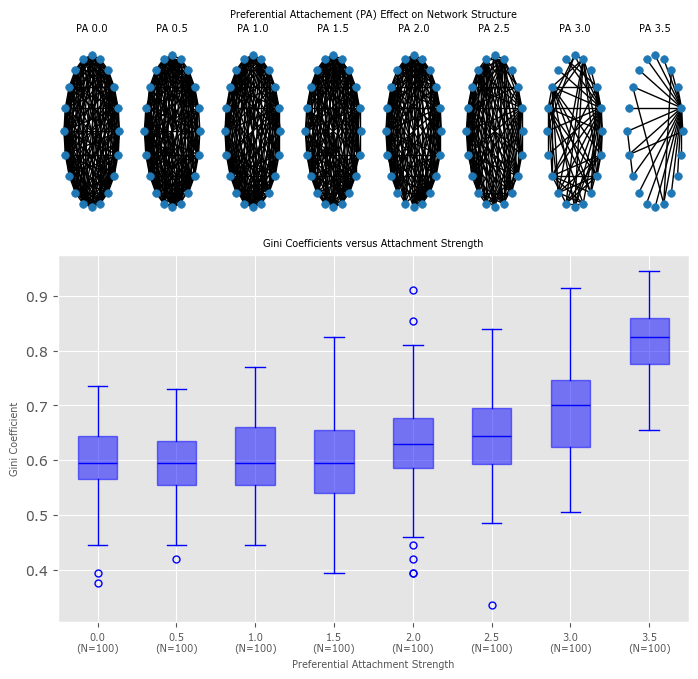

In [15]:
parameter_levels = preferential_strength  # parameter levels
graphs_list = [nx.from_numpy_array(adj_matrix) for adj_matrix in adjacency_matrices]  # NetworkX graphs for each level
gini_results = gini_results # Gini coefficients data

# Create figure with a custom GridSpec layout
# fig = plt.figure(figsize=(15, 10))
# gs = gridspec.GridSpec(2, 1, height_ratios=[1, 2])

# Set figure size in inches to match Nature's requirements
# Width: 180 mm = 7.0866 inches, Height: 210 mm = 8.2677 inches
fig = plt.figure(figsize=(7.0866, 6.88))  # Dimensions in inches
gs = gridspec.GridSpec(2, 1, height_ratios=[1, 2])

# Top row for network visualizations
network_row = plt.subplot(gs[0, 0])
network_row.axis('off')  # Turn off the axis for the network panel
gs_inner = gridspec.GridSpecFromSubplotSpec(1, len(parameter_levels), subplot_spec=gs[0])
network_row.set_title('Preferential Attachement (PA) Effect on Network Structure', fontsize = 7, y = 1.075)

for i, graph in enumerate(graphs_list):
    ax = plt.subplot(gs_inner[i])
    pos = nx.circular_layout(graph)  # or any other layout algorithm
    nx.draw(graph, pos, ax=ax, node_size=30, with_labels=False)
    ax.set_title(f'PA {parameter_levels[i]}', fontsize = 7)
    ax.axis('off')  # Turn off the axis for individual network plots

# Bottom row for Gini coefficient box plots
boxplot_row = plt.subplot(gs[1, 0])
boxplot_row.boxplot(gini_results, 
                    positions=range(len(parameter_levels)), 
                    notch=False,
                    patch_artist=True,
                    boxprops=dict(facecolor="blue", color="blue", alpha=0.5),
                    whiskerprops=dict(color="blue"),
                    capprops=dict(color="blue"),
                    medianprops=dict(color="blue"),
                    flierprops=dict(marker='o', markeredgecolor='blue', markersize=5))
#boxplot_row.set_xticklabels(parameter_levels)
boxplot_row.set_xticklabels([f'{param}\n(N=100)' for param in parameter_levels], fontsize=7)
boxplot_row.set_title('Gini Coefficients versus Attachment Strength', fontsize = 7)
boxplot_row.set_xlabel('Preferential Attachment Strength', fontsize = 7)
boxplot_row.set_ylabel('Gini Coefficient', fontsize = 7)

plt.tight_layout()
# Save as a PDF in Nature-compatible size
plt.savefig("../Output/pa_gini_results.pdf", format="pdf", bbox_inches="tight")
plt.show()

It was clear from the simulation results that increased 'preferential_strength'---a stronger bias favouring highly connected agents---led to increased inequality. Network effects, therefore, can clearly have a significant impact on wealth distributions. 